Import

In [1]:

%load_ext autoreload
%autoreload 2

from model import *
from dataloader import *
from dataloader_utils import *
from yolo_utils import *
from loss import *

import matplotlib.pyplot as plt
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
import torch
import sys
sys.argv.append("-Xfrozen_modules=off")

%matplotlib inline


d:\anaconda3\Lib\site-packages\IPython\core\interactiveshell.py:3284: UserWarning: Config option `use_debugger` not recognized by `IPCompleter`.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
[IPKernelApp] {'header': {'msg_id': '247e69ee-73c4e3ca20c24502590e08b1_6300_46', 'msg_type': 'execute_reply', 'username': 'username', 'session': '247e69ee-73c4e3ca20c24502590e08b1', 'date': datetime.datetime(2023, 12, 25, 14, 18, 35, 226151, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '247e69ee-73c4e3ca20c24502590e08b1_6300_46', 'msg_type': 'execute_reply', 'parent_header': {'date': datetime.datetime(2023, 12, 25, 14, 18, 27, 482000, tzinfo=tzutc()), 'msg_id': 'e1c845f4-9271-4001-b142-9d93ddbc89ca', 'msg_type': 'execute_request', 'session': '98da08ea-aba6-44db-9b88-9dbd7bbbdaad', 'username': '16d99c80-b3e7-45dd-a972-fa607a47b34c', 'version': '5.2'}, 'content': {'status': 'ok', 'execution_count': 1, 'user_expressions': {}, 'payload': []}, 'metadata': {'started': d

Load data

In [4]:
dataloader = DataLoader()
dataloader.load_data()

Loading data...
Loading data done.
Train set size:  1540
Test set size:  173


Show data

In [ ]:
np.random.seed(42)

# randomly select an image
idx = np.random.randint(len(dataloader.train_images))
# make sure idx is not out of bound
idx = max(0, min(idx, len(dataloader.train_images) - 1))
image = dataloader.train_images[idx]
label = dataloader.train_labels[idx]
boxes = dataloader.train_msg[idx]["boxes"]
original_image = dataloader.train_msg[idx]["original_image"]
original_boxes = dataloader.train_msg[idx]["original_boxes"]

# plot original image
print(original_image.shape)
print(original_boxes)
plt.figure(figsize=(4, 4))
plt.imshow(original_image)
for box in original_boxes:
    xmin = box["xmin"]
    ymin = box["ymin"]
    xmax = box["xmax"]
    ymax = box["ymax"]
    # plot bounding box, a rectangle
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="red", linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(xmin, ymin, box["class"], color="red", fontsize=12)

# plot the image
plt.figure(figsize=(4, 4))
plt.imshow(image)
for box in boxes:
    xmin = box["xmin"]
    ymin = box["ymin"]
    xmax = box["xmax"]
    ymax = box["ymax"]
    # plot bounding box, a rectangle
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="green", linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(xmin, ymin, box["class"], color="green", fontsize=12)
    # plot the center of the bounding box
    plt.plot((xmin + xmax) / 2, (ymin + ymax) / 2, "ro")

# mark the grids of the image
grid_size = INPUT_SIDE / N_GRID_SIDE
for i in range(N_GRID_SIDE):
    for j in range(N_GRID_SIDE):
        rect = plt.Rectangle((i * grid_size, j * grid_size), grid_size, grid_size, fill=False, edgecolor="blue", linewidth=1)
        plt.gca().add_patch(rect)

plt.show()

# show the non-zero numbers of the label
label = label.reshape(N_GRID_SIDE, N_GRID_SIDE, 5 * N_BBOX + N_CLASSES)
for i in range(N_GRID_SIDE):
    for j in range(N_GRID_SIDE):
        if label[i, j, 4] != 0:
            print(label[i, j])
        

# label2boxes
pred_boxes = label2box(label)
pred_boxes = non_max_suppression(pred_boxes)
print(pred_boxes)

# plot the image
plt.figure(figsize=(4, 4))
plt.imshow(image)
for box in pred_boxes:
    xmin = box["xmin"]
    ymin = box["ymin"]
    xmax = box["xmax"]
    ymax = box["ymax"]
    # plot bounding box, a rectangle
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="green", linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(xmin, ymin, box["class"], color="green", fontsize=12)
    # plot the center of the bounding box
    plt.plot((xmin + xmax) / 2, (ymin + ymax) / 2, "ro")

plt.show()


Test yolo utils

In [2]:
batch_size = BATCH_SIZE
train_lab = [0.5, 0.5, 0.5, 0.5, 1, 0.5, 0.5, 0.5, 0.5, 1]
# Train labels are zeros, except for the first grid cell
train_label = np.zeros((batch_size, N_GRID_SIDE, N_GRID_SIDE, 5 * N_BBOX + N_CLASSES))
train_label[0, 0, 0, :10] = train_lab
train_label = torch.from_numpy(train_label).float()

train_forward = torch.zeros((batch_size, N_GRID_SIDE, N_GRID_SIDE, 5 * N_BBOX + N_CLASSES))

loss = yolo_loss_be(train_forward, train_label)
print(loss)



[IPKernelApp] 
*** MESSAGE TYPE:execute_request***
[IPKernelApp]    Content: {'silent': False, 'store_history': True, 'user_expressions': {}, 'allow_stdin': True, 'stop_on_error': False, 'code': 'batch_size = BATCH_SIZE\ntrain_lab = [0.5, 0.5, 0.5, 0.5, 1, 0.5, 0.5, 0.5, 0.5, 1]\n# Train labels are zeros, except for the first grid cell\ntrain_label = np.zeros((batch_size, N_GRID_SIDE, N_GRID_SIDE, 5 * N_BBOX + N_CLASSES))\ntrain_label[0, 0, 0, :10] = train_lab\ntrain_label = torch.from_numpy(train_label).float()\n\ntrain_forward = torch.zeros((batch_size, N_GRID_SIDE, N_GRID_SIDE, 5 * N_BBOX + N_CLASSES))\n\nloss = yolo_loss_be(train_forward, train_label)\nprint(loss)\n\n'}
   --->
   
[IPKernelApp] execute_request: {'header': {'date': datetime.datetime(2023, 12, 25, 14, 18, 50, 842000, tzinfo=tzutc()), 'msg_id': '63232916-fb97-4d88-8a5d-9f4faccc2e1d', 'msg_type': 'execute_request', 'session': '98da08ea-aba6-44db-9b88-9dbd7bbbdaad', 'username': '16d99c80-b3e7-45dd-a972-fa607a47b34c', '

tensor(3.2812)


[IPKernelApp] {'header': {'msg_id': '247e69ee-73c4e3ca20c24502590e08b1_6300_55', 'msg_type': 'execute_reply', 'username': 'username', 'session': '247e69ee-73c4e3ca20c24502590e08b1', 'date': datetime.datetime(2023, 12, 25, 14, 18, 51, 200328, tzinfo=datetime.timezone.utc), 'version': '5.3'}, 'msg_id': '247e69ee-73c4e3ca20c24502590e08b1_6300_55', 'msg_type': 'execute_reply', 'parent_header': {'date': datetime.datetime(2023, 12, 25, 14, 18, 50, 842000, tzinfo=tzutc()), 'msg_id': '63232916-fb97-4d88-8a5d-9f4faccc2e1d', 'msg_type': 'execute_request', 'session': '98da08ea-aba6-44db-9b88-9dbd7bbbdaad', 'username': '16d99c80-b3e7-45dd-a972-fa607a47b34c', 'version': '5.2'}, 'content': {'status': 'ok', 'execution_count': 2, 'user_expressions': {}, 'payload': []}, 'metadata': {'started': datetime.datetime(2023, 12, 25, 14, 18, 50, 842813, tzinfo=datetime.timezone.utc), 'dependencies_met': True, 'engine': 'b160608b-439c-4c1f-bfdc-a8c298c4a817', 'status': 'ok'}, 'tracker': <zmq.sugar.tracker.Messag

Test model.

In [ ]:
train_images, train_labels = dataloader.train_images, dataloader.train_labels
test_images, test_labels = dataloader.test_images, dataloader.test_labels
train_boxes = [msg["boxes"] for msg in dataloader.train_msg]
test_boxes = [msg["boxes"] for msg in dataloader.test_msg]
net = Net()

# Test forward
import torch
batch_size = BATCH_SIZE
train_images = torch.Tensor(train_images[:batch_size])
train_labels = torch.Tensor(train_labels[:batch_size])
train_images = train_images.permute(0, 3, 1, 2)
forward = net.forward(train_images)
print("Forward shape: ", forward.shape)
print("Label shape: ", train_labels.shape)
print("Label: ", train_labels[0, 0, 0, :])
print("Forward: ", forward[0, 0, 0, :])
 
loss = yolo_loss(forward, train_labels)
loss_vec = yolo_loss_vectorized(forward, train_labels)
print(loss)
print(loss_vec)


Load Weight.

In [5]:
net = Net()
net.load_weights("weights135-1220.pth", to_cpu=True)

Weights loaded.


compute map. visualize the result.

In [4]:

# Test predict
import torch

# Visualize the prediction

# Test on train images
train_images = dataloader.train_images[:20]
train_boxes = [msg["boxes"] for msg in dataloader.train_msg[:20]]
train_labels = dataloader.train_labels[:20]
train_labels = torch.Tensor(train_labels).float()
train_labels = train_labels.reshape(-1, N_GRID_SIDE, N_GRID_SIDE, 5 * N_BBOX + N_CLASSES)
train_images = np.array(train_images)
original_train_images = train_images
pred_labels = net.forward(torch.Tensor(train_images).float().permute(0, 3, 1, 2))
boxes = net.predict(train_images)

# print pred label and gt label
# find where the label is not zero
print(yolo_loss(pred_labels, train_labels))




C:\Users\hw\AppData\Local\Temp\ipykernel_4508\3984523571.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:264.)
  train_labels = torch.Tensor(train_labels).float()


tensor(0.1002, grad_fn=<DivBackward0>)


tensor([0.5938, 0.3672, 0.4062, 0.4040, 1.0000, 0.5938, 0.3672, 0.4062, 0.4040,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000])
tensor([0.6110, 0.4099, 0.4040, 0.4057, 0.9133, 0.8032, 0.2063, 0.0140, 0.0276,
        0.0020, 0.0065, 0.0070, 0.0042, 0.0065, 0.0076, 0.0042, 0.0143, 0.0011,
        0.0054, 0.9867, 0.0078, 0.0098, 0.0016, 0.0172, 0.0053, 0.0024, 0.0027,
        0.0104, 0.0066, 0.0018], grad_fn=<SliceBackward0>)


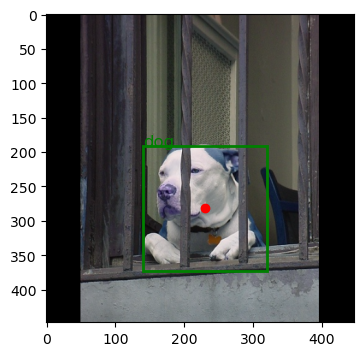

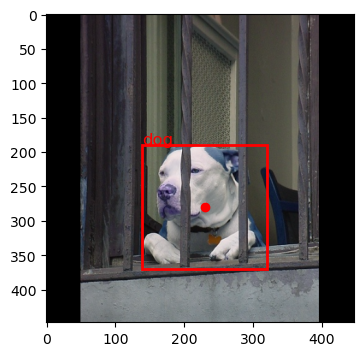

In [5]:
idx = 6
for i in range(N_GRID_SIDE):
    for j in range(N_GRID_SIDE):
        if train_labels[idx][i, j, 4] > 0:
            print(train_labels[idx][i, j, :])
            print(pred_labels[idx][i, j, :])

plt.figure(figsize=(4, 4))
plt.imshow(original_train_images[idx])
for box in boxes[idx]:
    xmin = box["xmin"]
    ymin = box["ymin"]
    xmax = box["xmax"]
    ymax = box["ymax"]
    # plot bounding box, a rectangle
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="green", linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(xmin, ymin, box["class"], color="green", fontsize=12)
    # plot the center of the bounding box
    plt.plot((xmin + xmax) / 2, (ymin + ymax) / 2, "ro")

plt.show()
# plot ground truth
plt.figure(figsize=(4, 4))
plt.imshow(original_train_images[idx])
for box in train_boxes[idx]:
    xmin = box["xmin"]
    ymin = box["ymin"]
    xmax = box["xmax"]
    ymax = box["ymax"]
    # plot bounding box, a rectangle
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="red", linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(xmin, ymin, box["class"], color="red", fontsize=12)
    # plot the center of the bounding box
    plt.plot((xmin + xmax) / 2, (ymin + ymax) / 2, "ro")




In [7]:
import sys
sys.argv.append("-Xfrozen_modules=off")

# Test images
test_images = dataloader.test_images
test_images = np.array(test_images)
original_test_images = test_images
print(test_images.shape)
test_boxes = [msg["boxes"] for msg in dataloader.test_msg]
mAP = net.evaluate(test_images, test_boxes)
test_images = test_images[0:32]
test_boxes = test_boxes[0:32]
boxes_ = net.predict(test_images)
print(mAP)


(173, 448, 448, 3)


: 

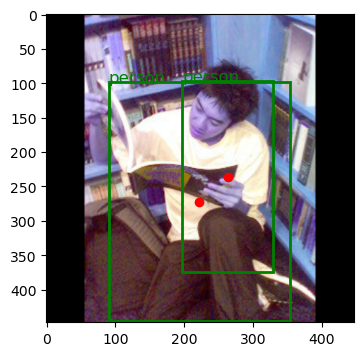

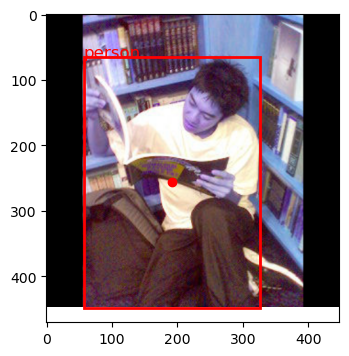

In [22]:
idx = 16

plt.figure(figsize=(4, 4))
plt.imshow(original_test_images[idx])
for box in boxes_[idx]:
    xmin = box["xmin"]
    ymin = box["ymin"]
    xmax = box["xmax"]
    ymax = box["ymax"]
    # plot bounding box, a rectangle
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="green", linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(xmin, ymin, box["class"], color="green", fontsize=12)
    # plot the center of the bounding box
    plt.plot((xmin + xmax) / 2, (ymin + ymax) / 2, "ro")

plt.show()

# plot ground truth
plt.figure(figsize=(4, 4))
plt.imshow(original_test_images[idx])
for box in test_boxes[idx]:
    xmin = box["xmin"]
    ymin = box["ymin"]
    xmax = box["xmax"]
    ymax = box["ymax"]
    # plot bounding box, a rectangle
    rect = plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor="red", linewidth=2)
    plt.gca().add_patch(rect)
    plt.text(xmin, ymin, box["class"], color="red", fontsize=12)
    # plot the center of the bounding box
    plt.plot((xmin + xmax) / 2, (ymin + ymax) / 2, "ro")

plt.show()